### Pre-procesamiento:

In [1]:
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional

import tensorflow as tf

In [2]:
corpus=[]
target=[]
edad=[]
sexo=[]
severidad=[]
archivo=open("dataset_elpino.csv",encoding="utf-8")
header=archivo.readline().strip().split(";")
features=[]
for col in header:
    col=col.split("-")[0].strip()
    if col.startswith("Diag") or col.startswith("Proc"):
        col=col.split(" ")
        col=col[0]+col[1]
    features.append(col)
for linea in archivo:
    row=[]
    linea=linea.strip().split(";")
    for i in range(len(linea)):
        col=linea[i].split("-")[0].strip()
        if i==67:
            grd=col
            #target.append(grd[-1])
            target.append(grd)
        elif i==66:
            sexo.append(1 if col=="Mujer" else 0)
        elif i==65:
            edad.append(int(col))
        else:
            row.append(col)
    corpus.append(row)

In [3]:
df = pd.DataFrame(corpus,columns=features[:-3])
df["GRD"] = target

In [4]:
diagnosticos = [f'Diag{str(i).zfill(2)}' for i in range(1, 11)]
procedimientos =[f'Proced{str(i).zfill(2)}' for i in range(1, 31)]
cols = diagnosticos + procedimientos
print(cols)

['Diag01', 'Diag02', 'Diag03', 'Diag04', 'Diag05', 'Diag06', 'Diag07', 'Diag08', 'Diag09', 'Diag10', 'Proced01', 'Proced02', 'Proced03', 'Proced04', 'Proced05', 'Proced06', 'Proced07', 'Proced08', 'Proced09', 'Proced10', 'Proced11', 'Proced12', 'Proced13', 'Proced14', 'Proced15', 'Proced16', 'Proced17', 'Proced18', 'Proced19', 'Proced20', 'Proced21', 'Proced22', 'Proced23', 'Proced24', 'Proced25', 'Proced26', 'Proced27', 'Proced28', 'Proced29', 'Proced30']


In [5]:
df['GRD'] = df['GRD'].astype(str).str[:5] #elimina ultimo elemento del GRD

df.head(5)

,Diag01,Diag02,Diag03,Diag04,Diag05,Diag06,Diag07,Diag08,Diag09,Diag10,...,Proced22,Proced23,Proced24,Proced25,Proced26,Proced27,Proced28,Proced29,Proced30,GRD
0,A41.8,B37.6,I39.8,N10,B96.1,L89.9,L08.9,B96.2,A41.5,J86.9,...,99.04,90.39,99.84,88.72,90.42,90.52,91.39,91.33,87.03,18410
1,U07.1,J12.8,R06.0,R05,R50.9,Z29.0,Z01.7,J96.00,J94.2,J92.9,...,91.69,87.44,91.62,90.43,91.39,90.52,91.32,96.59,90.99,04101
2,K56.5,R57.2,R57.1,J80,Y95,J15.0,U82.2,B95.6,B96.8,B37.1,...,91.33,90.39,99.84,91.73,90.53,99.26,89.39,89.66,89.65,04101
3,K76.8,K66.1,N18.5,D64.9,E87.5,E87.2,J81,N17.8,J44.9,R41.0,...,96.59,94.19,57.94,00.13,00.17,99.04,99.18,99.21,99.23,04102
4,T81.0,Y83.2,S31.1,S36.80,W31.62,J96.09,J15.0,U82.2,U07.1,N39.0,...,99.21,99.29,90.52,91.39,91.32,93.90,99.15,96.59,45.13,04102


In [6]:
def diagnosticos_primeros_3(df, diag_cols):

    def subgrupo_icd10(code):
        if pd.isnull(code) or code.strip() == '':
            return 'UNK'
        return code[:3]

    df_copy = df.copy()
    for col in diag_cols:
        df_copy[col] = df_copy[col].astype(str).apply(subgrupo_icd10)

    return df_copy

df_grouped = diagnosticos_primeros_3(df, diagnosticos)

df_grouped.head(5)

,Diag01,Diag02,Diag03,Diag04,Diag05,Diag06,Diag07,Diag08,Diag09,Diag10,...,Proced22,Proced23,Proced24,Proced25,Proced26,Proced27,Proced28,Proced29,Proced30,GRD
0,A41,B37,I39,N10,B96,L89,L08,B96,A41,J86,...,99.04,90.39,99.84,88.72,90.42,90.52,91.39,91.33,87.03,18410
1,U07,J12,R06,R05,R50,Z29,Z01,J96,J94,J92,...,91.69,87.44,91.62,90.43,91.39,90.52,91.32,96.59,90.99,04101
2,K56,R57,R57,J80,Y95,J15,U82,B95,B96,B37,...,91.33,90.39,99.84,91.73,90.53,99.26,89.39,89.66,89.65,04101
3,K76,K66,N18,D64,E87,E87,J81,N17,J44,R41,...,96.59,94.19,57.94,00.13,00.17,99.04,99.18,99.21,99.23,04102
4,T81,Y83,S31,S36,W31,J96,J15,U82,U07,N39,...,99.21,99.29,90.52,91.39,91.32,93.90,99.15,96.59,45.13,04102


In [7]:
def procedimientos_primeros_2(df, proc_cols):

    def subgrupo_icd9(code):
        if pd.isnull(code) or code.strip() == '':
            return 'UNK'
        return code[:2]

    df_copy = df.copy()
    for col in proc_cols:
        df_copy[col] = df_copy[col].astype(str).apply(subgrupo_icd9)

    return df_copy

df_grouped = procedimientos_primeros_2(df_grouped, procedimientos)

df_grouped.head(5)

,Diag01,Diag02,Diag03,Diag04,Diag05,Diag06,Diag07,Diag08,Diag09,Diag10,...,Proced22,Proced23,Proced24,Proced25,Proced26,Proced27,Proced28,Proced29,Proced30,GRD
0,A41,B37,I39,N10,B96,L89,L08,B96,A41,J86,...,99,90,99,88,90,90,91,91,87,18410
1,U07,J12,R06,R05,R50,Z29,Z01,J96,J94,J92,...,91,87,91,90,91,90,91,96,90,04101
2,K56,R57,R57,J80,Y95,J15,U82,B95,B96,B37,...,91,90,99,91,90,99,89,89,89,04101
3,K76,K66,N18,D64,E87,E87,J81,N17,J44,R41,...,96,94,57,00,00,99,99,99,99,04102
4,T81,Y83,S31,S36,W31,J96,J15,U82,U07,N39,...,99,99,90,91,91,93,99,96,45,04102


### Modelo 1: Red Neuronal

In [8]:
"""
NN mejorada. Procedimiento y diagnostico agrupado por capitulo, GRD se elimina ultimo elemento.
Capa adicional

"""

df_model = df_grouped.copy()

encoders = {}
for col in cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    encoders[col] = le

target_encoder = LabelEncoder()
df_model['GRD'] = target_encoder.fit_transform(df_model['GRD'].astype(str))
y = to_categorical(df_model['GRD'])

X_train, X_test, y_train, y_test = train_test_split(df_model[cols], y, test_size=0.2, random_state=42)

#Embedding:

inputs = []
embeddings = []

def get_embedding_dim(vocab_size):
    return int(np.log2(vocab_size)) + 1 #Embedding dinamico acorde tamaño vocab

for col in cols:
    vocab_size = df_model[col].nunique() + 1
    inp = Input(shape=(1,))
    emb_dim = get_embedding_dim(vocab_size)
    emb = Embedding(input_dim=vocab_size, output_dim=emb_dim)(inp)
    emb = Flatten()(emb)
    inputs.append(inp)
    embeddings.append(emb)

x = Concatenate()(embeddings)

#Capas:

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

X_train_inputs = [X_train[col].values for col in cols]
X_test_inputs = [X_test[col].values for col in cols]

early_stop = EarlyStopping(patience=15, restore_best_weights=True)

model.fit(X_train_inputs, y_train, epochs=50, batch_size=128,
          validation_split=0.2, callbacks=[early_stop])

loss, accuracy = model.evaluate(X_test_inputs, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.1384 - loss: 4.8583 - val_accuracy: 0.2670 - val_loss: 4.9858
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4889 - loss: 2.8539 - val_accuracy: 0.3258 - val_loss: 4.3949
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6466 - loss: 1.8240 - val_accuracy: 0.3807 - val_loss: 3.8150
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7420 - loss: 1.3371 - val_accuracy: 0.5442 - val_loss: 3.2231
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8114 - loss: 0.9742 - val_accuracy: 0.6734 - val_loss: 2.5999
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8518 - loss: 0.7753 - val_accuracy: 0.7918 - val_loss: 1.9369
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8693 - loss: 0.6410 - val_accuracy: 0.8292 - val_loss: 1.3147
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8966 - loss: 0.5064 - val_accuracy: 0.8489 - 

In [9]:
model.save('nn.h5', save_format='h5')

In [37]:
model_nn= tf.keras.models.load_model('nn.h5')

In [38]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_pred = model_nn.predict(X_test_inputs)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

y_test_bin = y_test
n_classes = y_test.shape[1]

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


In [39]:
y_pred_labels = np.argmax(y_pred, axis=1)

predicted_counts = pd.Series(y_pred_labels).value_counts()

class_names = target_encoder.inverse_transform(predicted_counts.index)

predicted_freq_df = pd.DataFrame({
    'GRD': class_names,
    'Cuenta': predicted_counts.values
})

print("10 mas predichas:")
print(predicted_freq_df.head(10))

print("\n10 menos predichas:")
print(predicted_freq_df.tail(10))


10 mas predichas:
     GRD  Cuenta
0  14610     206
1  14612     182
2  14613     158
3  15817     129
4  07114     106
5  13416      99
6  11412      83
7  04416      78
8  04415      74
9  04102      69

10 menos predichas:
       GRD  Cuenta
120  08416       1
121  05106       1
122  06416       1
123  05114       1
124  01426       1
125  06414       1
126  21411       1
127  05424       1
128  09120       1
129  09414       1


<ipython-input-40-f6d62b719be4>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


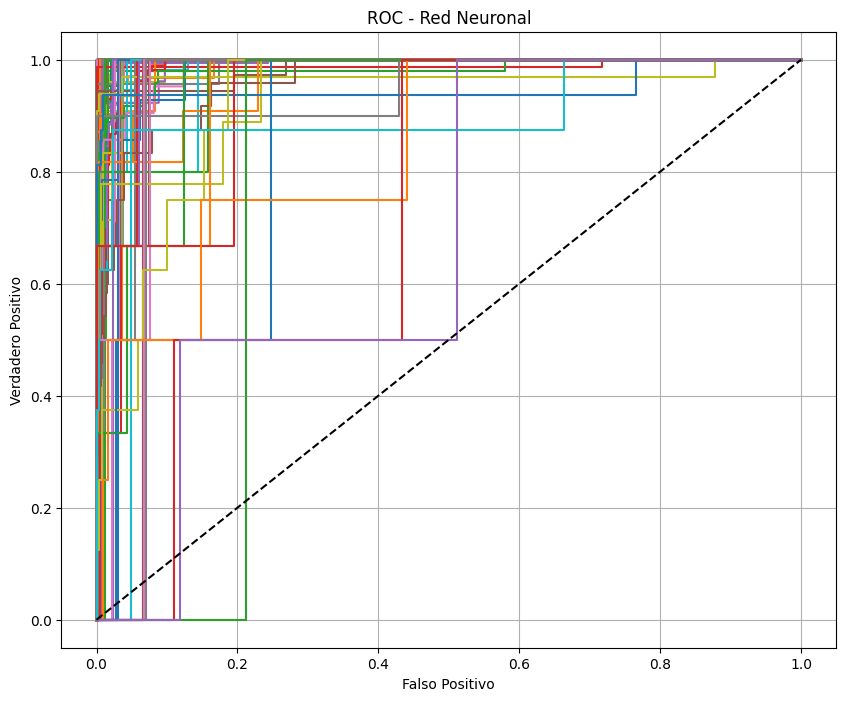

In [40]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0:
          continue
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

sorted_auc = sorted(roc_auc.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for cls_idx, auc_score in sorted_auc:
    plt.plot(fpr[cls_idx], tpr[cls_idx],
             label=f'Clase {target_encoder.classes_[cls_idx]} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('ROC - Red Neuronal')
plt.grid()
plt.show()

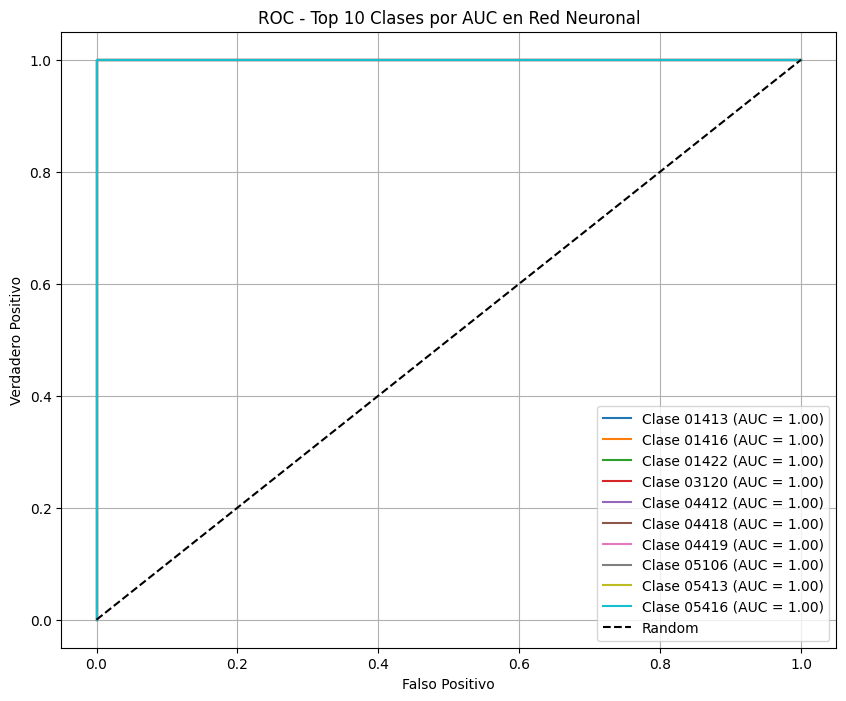

In [41]:
top_n = 10

plt.figure(figsize=(10, 8))
count = 0

for cls_idx, auc_score in sorted_auc:
    plt.plot(fpr[cls_idx], tpr[cls_idx],
             label=f'Clase {target_encoder.classes_[cls_idx]} (AUC = {auc_score:.2f})')
    count += 1
    if count == top_n:
        break

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title(f'ROC - Top {top_n} Clases por AUC en Red Neuronal')
plt.legend(loc='lower right')
plt.grid()
plt.show()

#diez mas bajas y relevancia en dataset (peso)

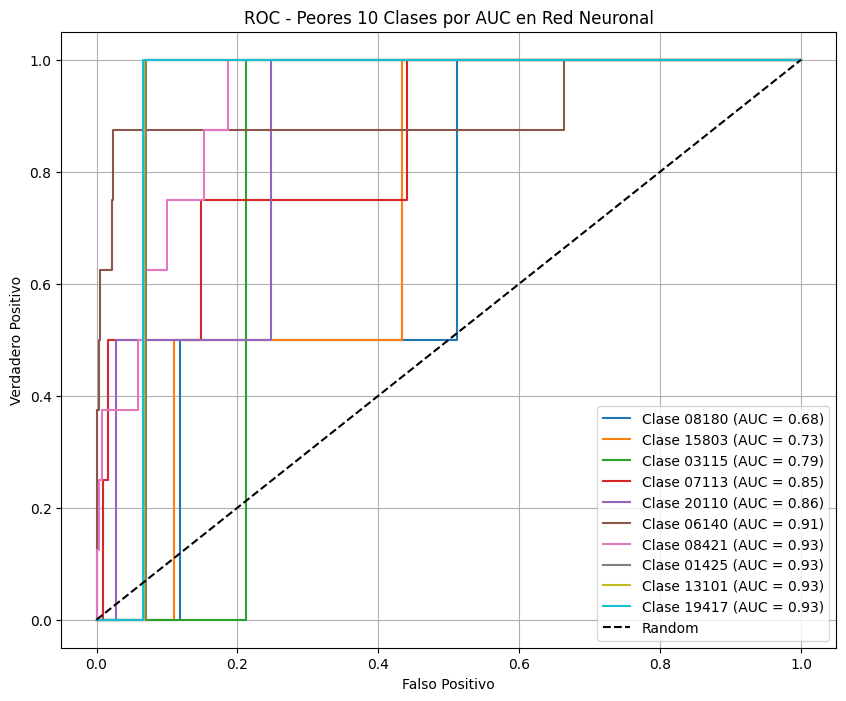

In [18]:
sorted_auc = sorted(roc_auc.items(), key=lambda x: x[1])
bottom_n = 10

plt.figure(figsize=(10, 8))
count = 0

for cls_idx, auc_score in sorted_auc:
    if np.isnan(auc_score):
        continue
    if np.sum(y_test[:, cls_idx]) == 0:
        continue
    plt.plot(fpr[cls_idx], tpr[cls_idx],
             label=f'Clase {target_encoder.classes_[cls_idx]} (AUC = {auc_score:.2f})')
    count += 1
    if count == bottom_n:
        break

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title(f'ROC - Peores {bottom_n} Clases por AUC en Red Neuronal')
plt.legend(loc='lower right')
plt.grid()
plt.show()

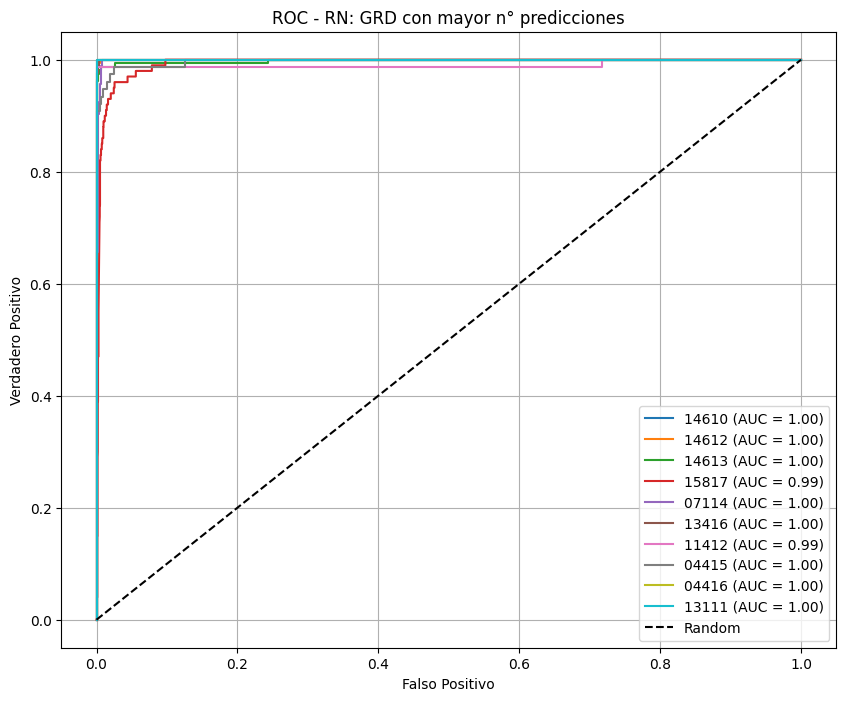

In [19]:
target_grds = ['14610', '14612', '14613','15817',
               '07114', '13416', '11412', '04415',
               '04416', '13111']

target_indices = [np.where(target_encoder.classes_ == grd)[0][0] for grd in target_grds]

plt.figure(figsize=(10, 8))
for cls_idx in target_indices:
    plt.plot(fpr[cls_idx], tpr[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AUC = {roc_auc[cls_idx]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('ROC - RN: GRD con mayor n° predicciones')
plt.legend(loc='lower right')
plt.grid()
plt.show()

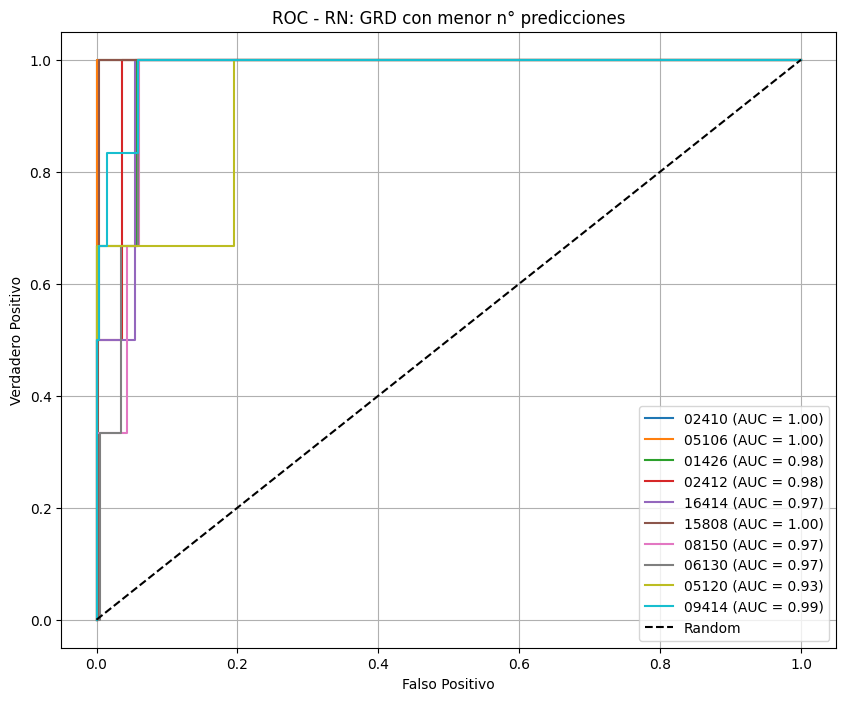

In [20]:
target_grds = ['02410', '05106', '01426', '02412',
               '16414', '15808', '08150', '06130',
               '05120', '09414']


target_indices = [np.where(target_encoder.classes_ == grd)[0][0] for grd in target_grds]

plt.figure(figsize=(10, 8))
for cls_idx in target_indices:
    plt.plot(fpr[cls_idx], tpr[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AUC = {roc_auc[cls_idx]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('ROC - RN: GRD con menor n° predicciones')
plt.legend(loc='lower right')
plt.grid()
plt.show()

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


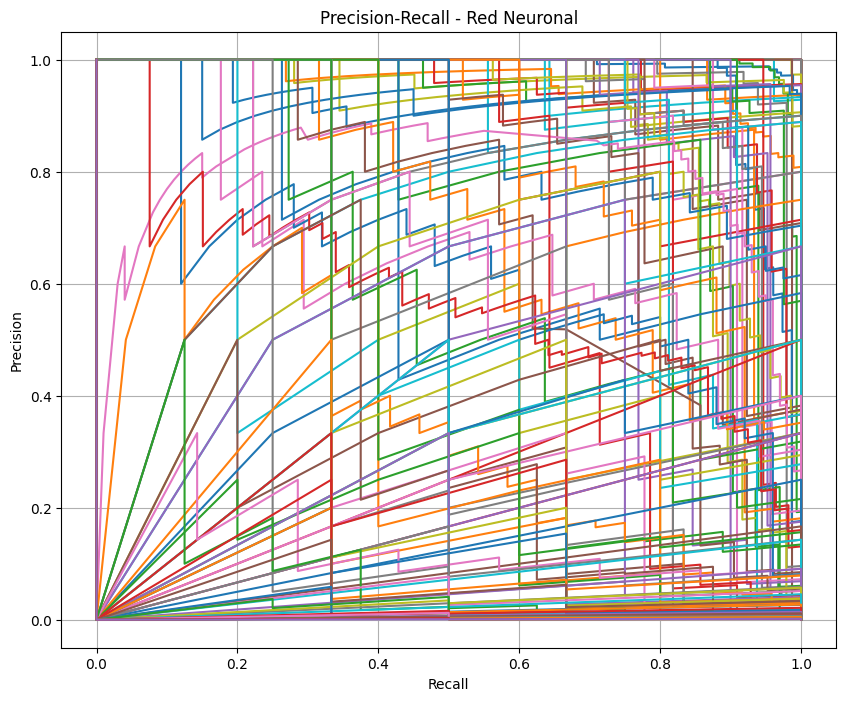

In [21]:
y_pred_probs = model.predict(X_test_inputs)

n_classes = y_test.shape[1]

average_precision = dict()
precision = dict()
recall = dict()

for i in range(n_classes):
    if np.sum(y_test[:, i]) == 0:
          continue
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_probs[:, i])

sorted_classes = sorted(average_precision.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 8))
for i, (cls_idx, auc_score) in enumerate(sorted_classes):
    plt.plot(recall[cls_idx], precision[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AP = {auc_score:.2f})')

plt.title(f'Precision-Recall - Red Neuronal')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

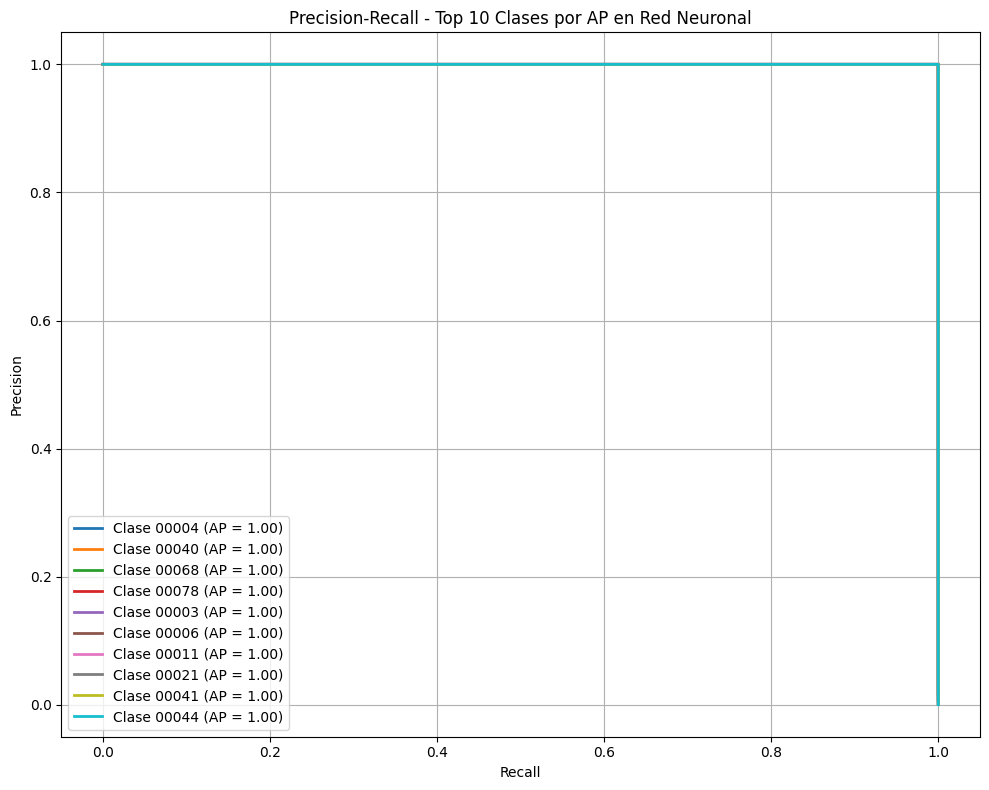

In [22]:
top_k = 10
top_classes = [cls for cls, _ in sorted_classes[:top_k]]

plt.figure(figsize=(10, 8))
for i in top_classes:
    plt.plot(recall[i], precision[i], lw=2, label=f'Clase {i:05} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall - Top 10 Clases por AP en Red Neuronal')
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

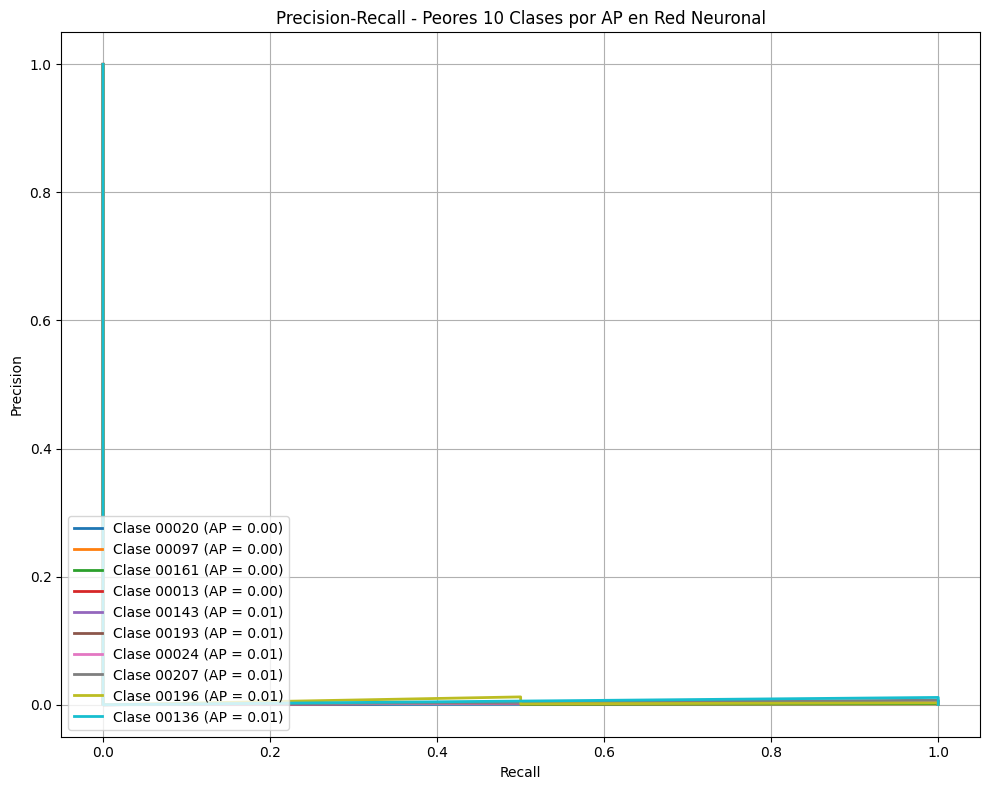

In [23]:
sorted_classes = sorted(average_precision.items(), key=lambda x: x[1])
top_k = 10
bottom_classes = [cls for cls, _ in sorted_classes[:top_k]]

plt.figure(figsize=(10, 8))
for i in bottom_classes:
    if np.sum(y_test[:, i]) == 0:
            continue
    plt.plot(recall[i], precision[i], lw=2, label=f'Clase {i:05} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall - Peores {top_n} Clases por AP en Red Neuronal')
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

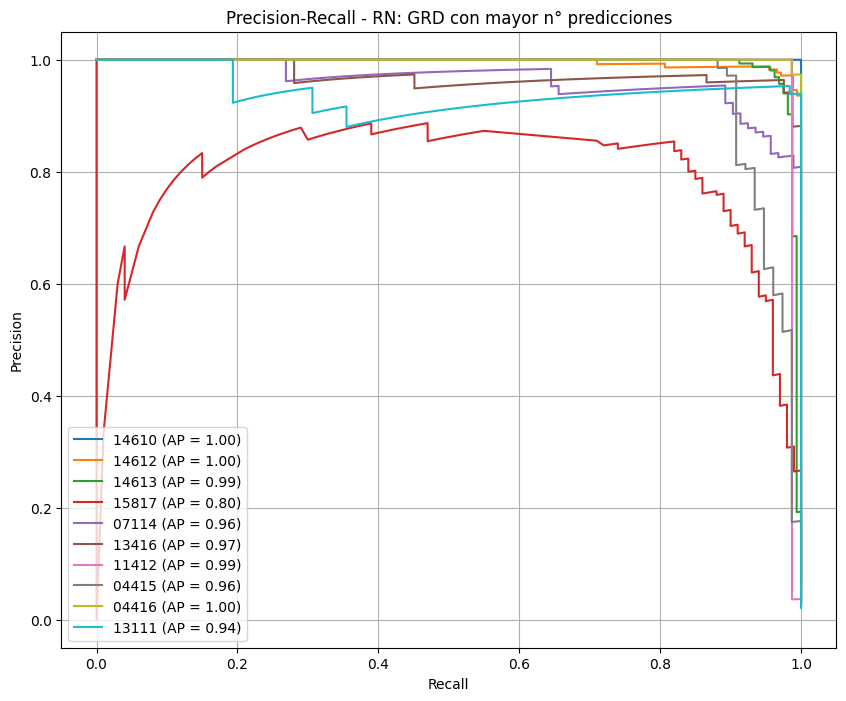

In [24]:
target_grds = ['14610', '14612', '14613','15817',
               '07114', '13416', '11412', '04415',
               '04416', '13111']

target_indices = [np.where(target_encoder.classes_ == grd)[0][0] for grd in target_grds]

plt.figure(figsize=(10, 8))
for cls_idx in target_indices:
    plt.plot(recall[cls_idx], precision[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AP = {average_precision[cls_idx]:.2f})')


plt.title(f'Precision-Recall - RN: GRD con mayor n° predicciones')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid()
plt.show()

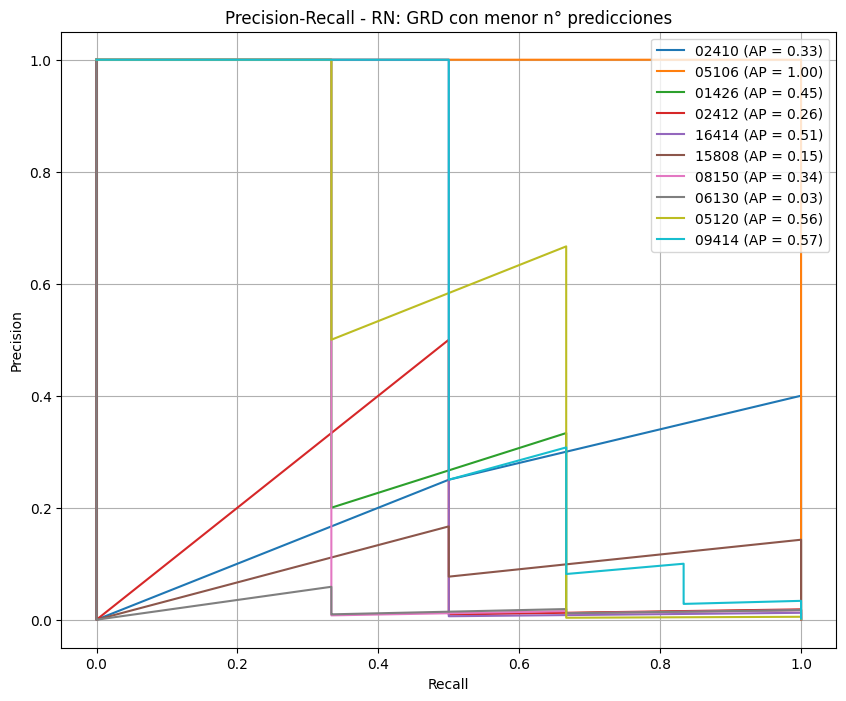

In [25]:
target_grds = target_grds = ['02410', '05106', '01426', '02412',
               '16414', '15808', '08150', '06130',
               '05120', '09414']

target_indices = [np.where(target_encoder.classes_ == grd)[0][0] for grd in target_grds]

plt.figure(figsize=(10, 8))
for cls_idx in target_indices:
    plt.plot(recall[cls_idx], precision[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AP = {average_precision[cls_idx]:.2f})')


plt.title(f'Precision-Recall - RN: GRD con menor n° predicciones')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.grid()
plt.show()

### Modelo 2: LSTM

In [28]:
df_model_2 = df_grouped.copy()

all_codes = pd.Series(df_model_2[cols].values.ravel())
code_encoder = LabelEncoder()
code_encoder.fit(all_codes.astype(str))

diag_seq = df_model_2[diagnosticos].apply(lambda x: code_encoder.transform(x.astype(str)), axis=1)
proc_seq = df_model_2[procedimientos].apply(lambda x: code_encoder.transform(x.astype(str)), axis=1)

max_diag_len = len(diagnosticos)
max_proc_len = len(procedimientos)

X_diag = np.array(list(diag_seq))
X_proc = np.array(list(proc_seq))

target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(df_model_2['GRD'].astype(str))
y = to_categorical(y_encoded)

X_diag_train, X_diag_test, X_proc_train, X_proc_test, y_train, y_test = train_test_split(
    X_diag, X_proc, y, test_size=0.2, random_state=42
)

In [29]:
vocab_size = len(code_encoder.classes_)
embedding_dim = 128

diag_input = Input(shape=(max_diag_len,), name='diag_input')
proc_input = Input(shape=(max_proc_len,), name='proc_input')

#Capas LSTM:

diag_emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(diag_input)
proc_emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(proc_input)

diag_lstm = Bidirectional(LSTM(64, return_sequences=True))(diag_emb)
diag_lstm = Bidirectional(LSTM(32))(diag_lstm)

proc_lstm = Bidirectional(LSTM(64, return_sequences=True))(proc_emb)
proc_lstm = Bidirectional(LSTM(32))(proc_lstm)


x = Concatenate()([diag_lstm, proc_lstm])

#Capas:

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(y.shape[1], activation='softmax')(x)

model_lstm = Model(inputs=[diag_input, proc_input], outputs=output)
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
model_lstm.fit([X_diag_train, X_proc_train], y_train,
          validation_split=0.2,
          epochs=50, batch_size=64,
          callbacks=[early_stop])

loss, accuracy = model_lstm.evaluate([X_diag_test, X_proc_test], y_test)
print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.2681 - loss: 4.0712 - val_accuracy: 0.2708 - val_loss: 4.7610
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 160ms/step - accuracy: 0.6351 - loss: 1.9371 - val_accuracy: 0.2258 - val_loss: 3.9135
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step - accuracy: 0.7570 - loss: 1.2292 - val_accuracy: 0.7464 - val_loss: 2.4442
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.8260 - loss: 0.8508 - val_accuracy: 0.7116 - val_loss: 1.5624
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 56s 270ms/step - accuracy: 0.8539 - loss: 0.6691 - val_accuracy: 0.7700 - val_loss: 1.1279
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.8795 - loss: 0.5209 - val_accuracy: 0.7983 - val_loss: 0.9937
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.8976 - loss: 0.4382 - val_accuracy: 0.8266 - val_loss: 0.7806
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.9102 - loss: 0

In [30]:
model_lstm.save('lstm.h5')

In [36]:
model_lstm = tf.keras.models.load_model("lstm.h5")

In [35]:
y_pred_proba = model_lstm.predict([X_diag_test, X_proc_test])

92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step


In [ ]:
y_pred_labels = np.argmax(y_pred_proba, axis=1)

predicted_counts = pd.Series(y_pred_labels).value_counts()

class_names = target_encoder.inverse_transform(predicted_counts.index)

predicted_freq_df = pd.DataFrame({
    'GRD': class_names,
    'Cuenta': predicted_counts.values
})

print("10 mas predichas:")
print(predicted_freq_df.head(10))

print("\n10 menos predichas:")
print(predicted_freq_df.tail(10))

10 mas predichas:
     GRD  Cuenta
0  14610     217
1  14612     179
2  14613     159
3  15817     115
4  07114     106
5  13416      90
6  11412      83
7  04416      78
8  04415      76
9  13120      69

10 menos predichas:
       GRD  Cuenta
134  01426       1
135  08411       1
136  09120       1
137  12113       1
138  05414       1
139  04413       1
140  15810       1
141  06130       1
142  11414       1
143  09414       1


In [ ]:
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    if np.sum(y_test[:, i]) == 0:
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    pr_auc[i] = average_precision_score(y_test[:, i], y_pred_proba[:, i])

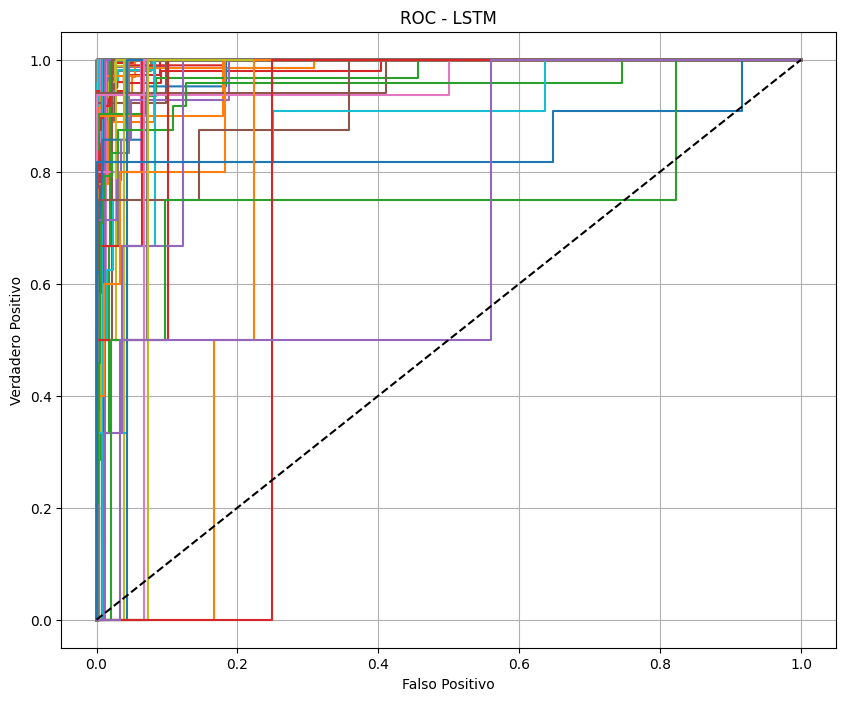

In [ ]:
sorted_roc = sorted(roc_auc.items(), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(10, 8))
for i, (cls_idx, auc_score) in enumerate(sorted_roc):
    plt.plot(fpr[cls_idx], tpr[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title(f'ROC - LSTM')
plt.grid()
plt.show()

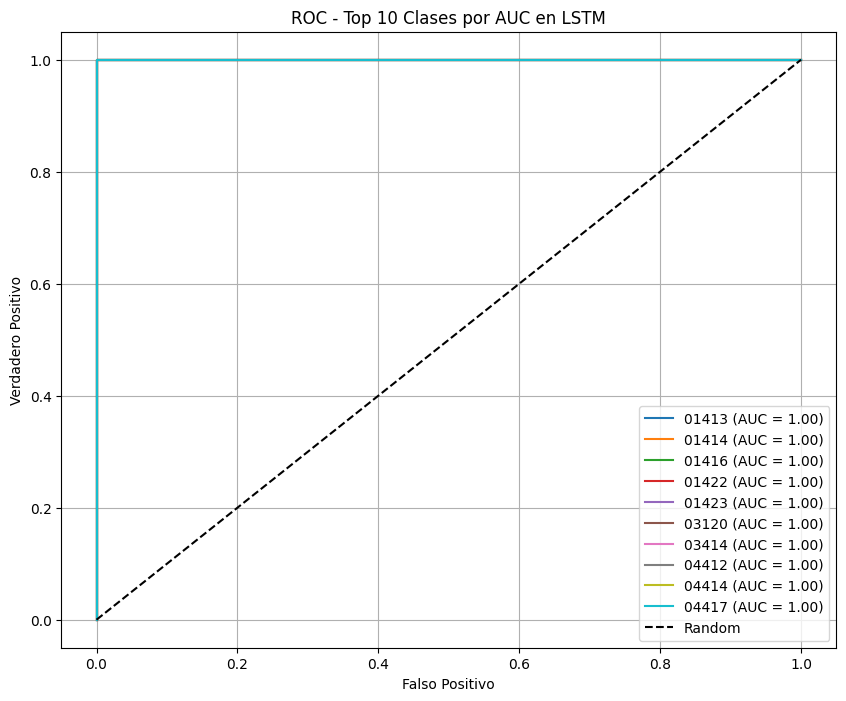

In [ ]:
sorted_roc = sorted(roc_auc.items(), key=lambda x: x[1], reverse=True)
top_n = 10

plt.figure(figsize=(10, 8))
for i, (cls_idx, auc_score) in enumerate(sorted_roc[:top_n]):
    plt.plot(fpr[cls_idx], tpr[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title(f'ROC - Top 10 Clases por AUC en LSTM')
plt.legend(loc='lower right')
plt.grid()
plt.show()

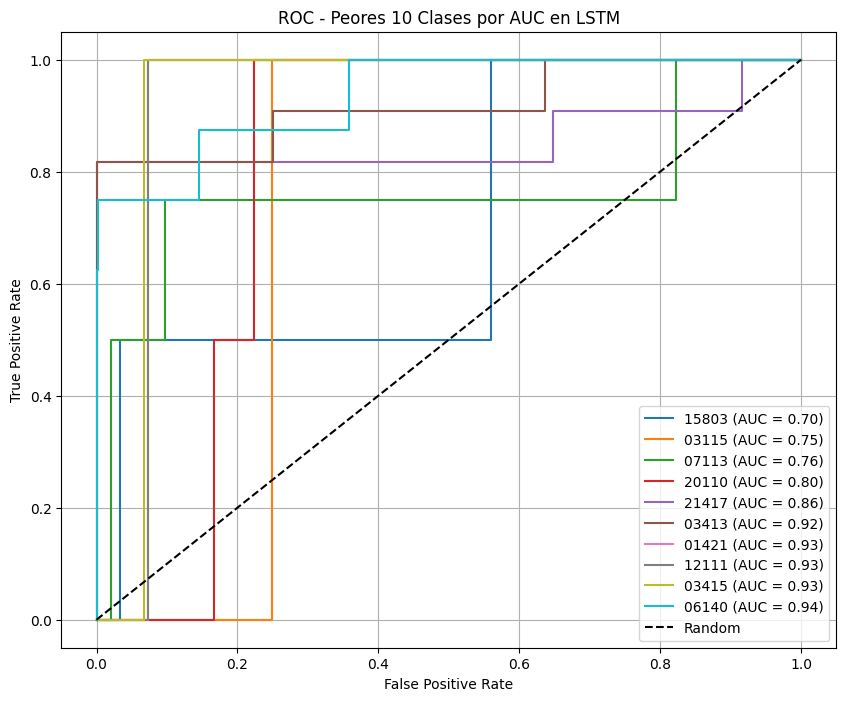

In [ ]:
sorted_roc = sorted(roc_auc.items(), key=lambda x: x[1])  # ascending order

bottom_n = 10
plt.figure(figsize=(10, 8))
for i, (cls_idx, auc_score) in enumerate(sorted_roc[:bottom_n]):
    plt.plot(fpr[cls_idx], tpr[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title(f'ROC - Peores 10 Clases por AUC en LSTM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

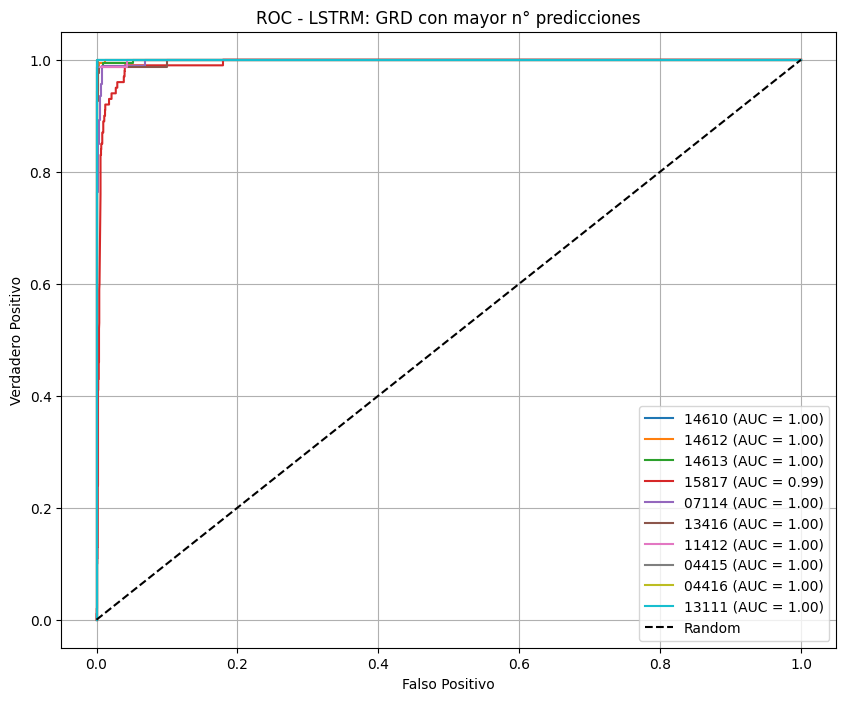

In [ ]:
target_grds = ['14610', '14612', '14613','15817',
               '07114', '13416', '11412', '04415',
               '04416', '13111']

target_indices = [np.where(target_encoder.classes_ == grd)[0][0] for grd in target_grds]

plt.figure(figsize=(10, 8))
for cls_idx in target_indices:
    plt.plot(fpr[cls_idx], tpr[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AUC = {roc_auc[cls_idx]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('ROC - LSTRM: GRD con mayor n° predicciones')
plt.legend(loc='lower right')
plt.grid()
plt.show()


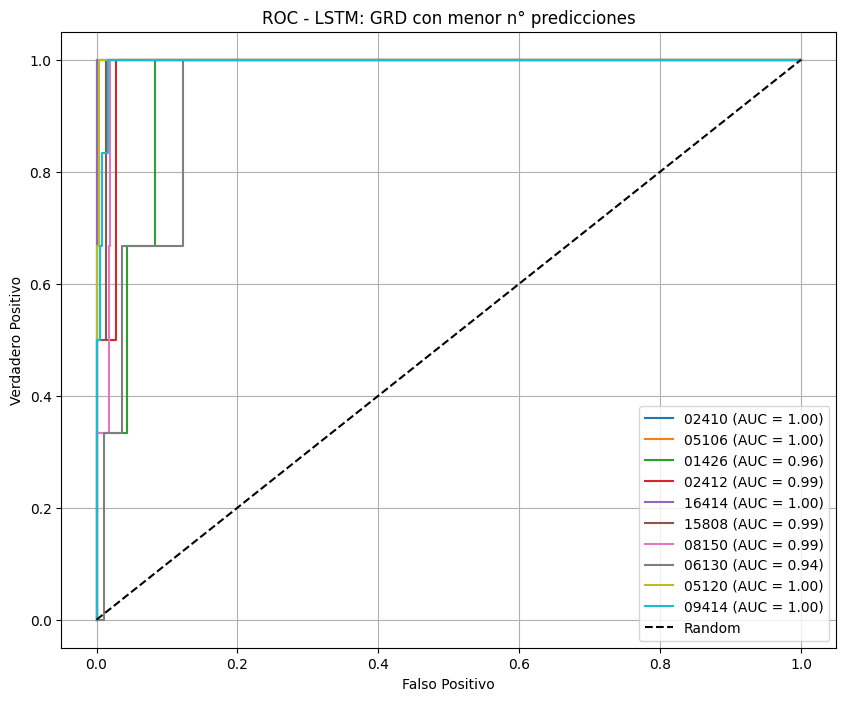

In [ ]:
target_grds = ['02410', '05106', '01426', '02412',
               '16414', '15808', '08150', '06130',
               '05120', '09414']


target_indices = [np.where(target_encoder.classes_ == grd)[0][0] for grd in target_grds]

plt.figure(figsize=(10, 8))
for cls_idx in target_indices:
    plt.plot(fpr[cls_idx], tpr[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AUC = {roc_auc[cls_idx]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('ROC - LSTM: GRD con menor n° predicciones')
plt.legend(loc='lower right')
plt.grid()
plt.show()

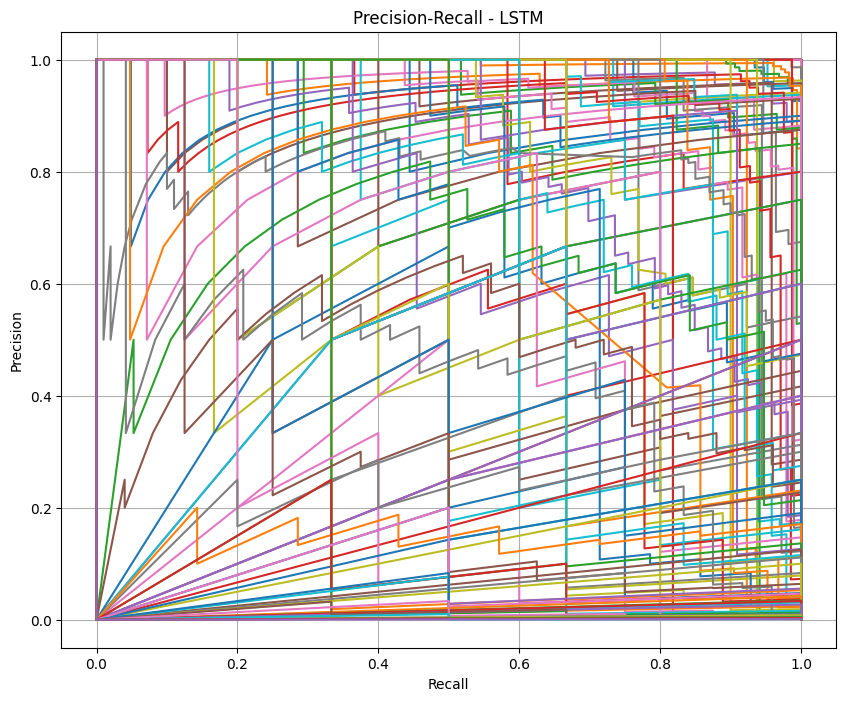

In [ ]:
sorted_pr = sorted(pr_auc.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 8))
for i, (cls_idx, auc_score) in enumerate(sorted_pr):
    plt.plot(recall[cls_idx], precision[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AP = {auc_score:.2f})')

plt.title(f'Precision-Recall - LSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

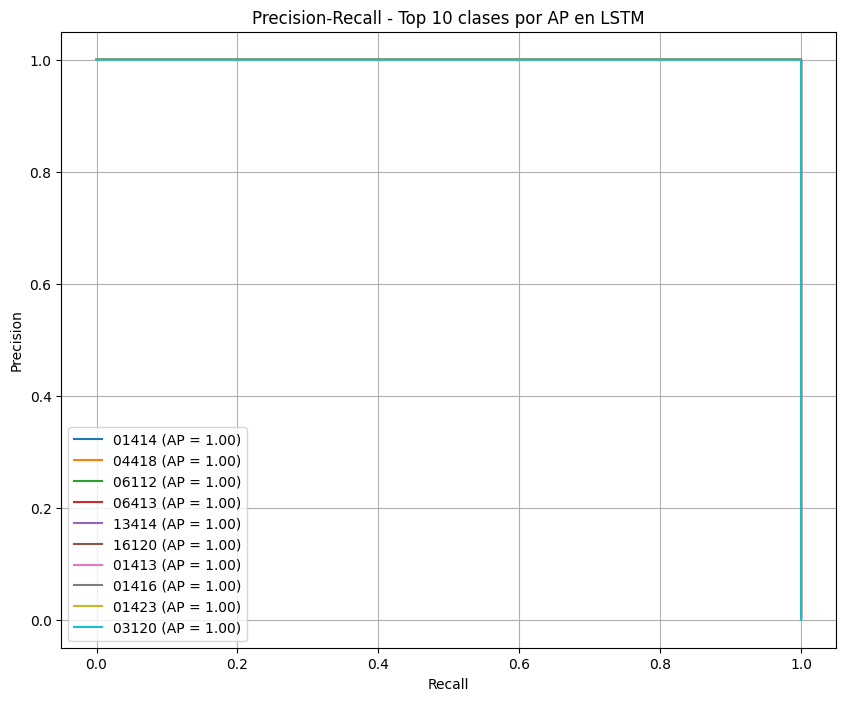

In [ ]:
sorted_pr = sorted(pr_auc.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 8))
for i, (cls_idx, auc_score) in enumerate(sorted_pr[:top_n]):
    plt.plot(recall[cls_idx], precision[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AP = {auc_score:.2f})')

plt.title(f'Precision-Recall - Top 10 clases por AP en LSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid()
plt.show()


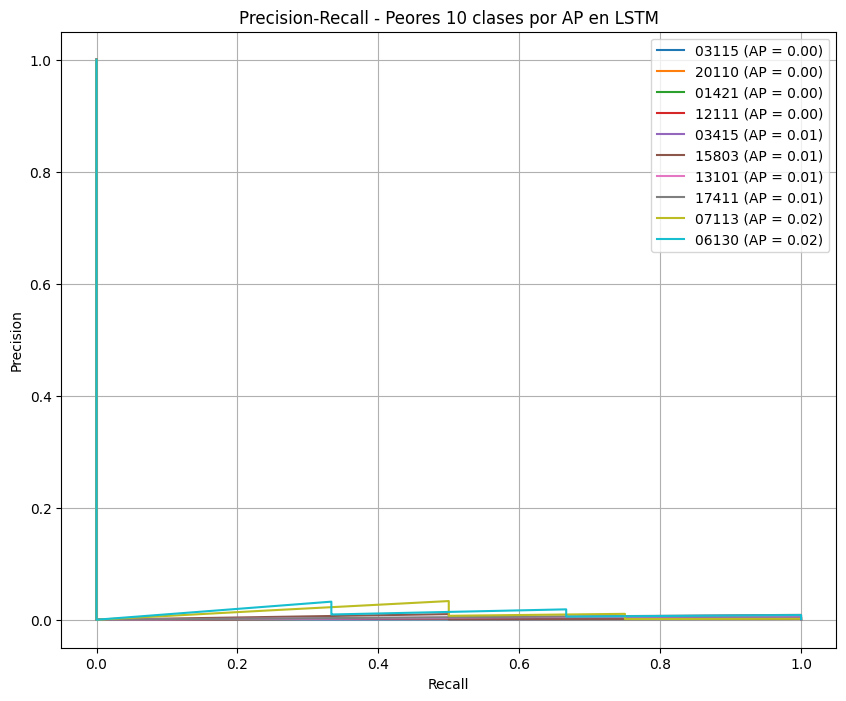

In [ ]:
sorted_pr = sorted(pr_auc.items(), key=lambda x: x[1])  # ascending order

plt.figure(figsize=(10, 8))
for i, (cls_idx, auc_score) in enumerate(sorted_pr[:bottom_n]):
    plt.plot(recall[cls_idx], precision[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AP = {auc_score:.2f})')

plt.title(f'Precision-Recall - Peores 10 clases por AP en LSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.grid()
plt.show()


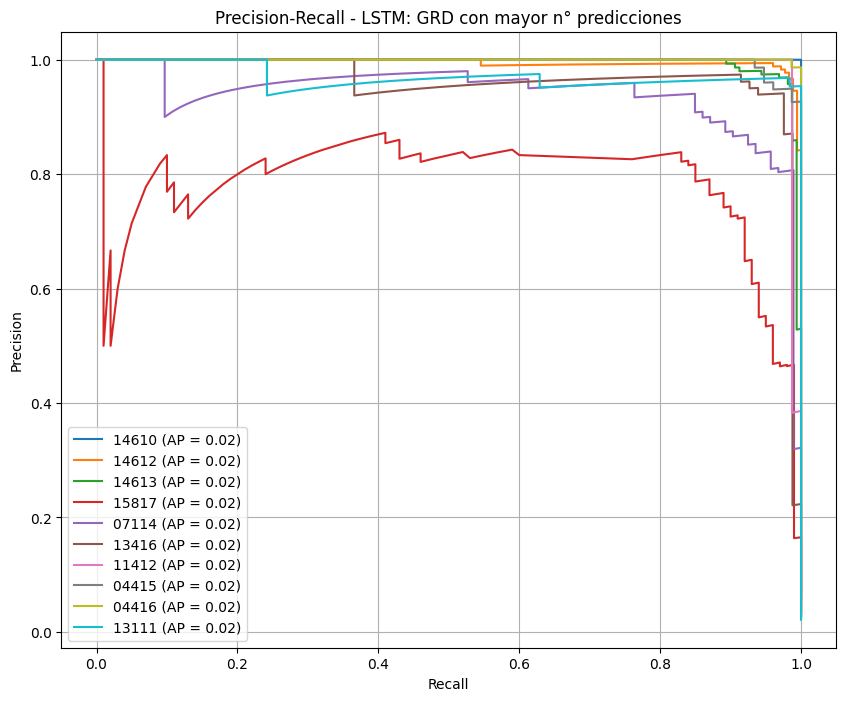

In [ ]:
target_grds = ['14610', '14612', '14613','15817',
               '07114', '13416', '11412', '04415',
               '04416', '13111']

target_indices = [np.where(target_encoder.classes_ == grd)[0][0] for grd in target_grds]

plt.figure(figsize=(10, 8))
for cls_idx in target_indices:
    plt.plot(recall[cls_idx], precision[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AP = {auc_score:.2f})')


plt.title(f'Precision-Recall - LSTM: GRD con mayor n° predicciones')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid()
plt.show()

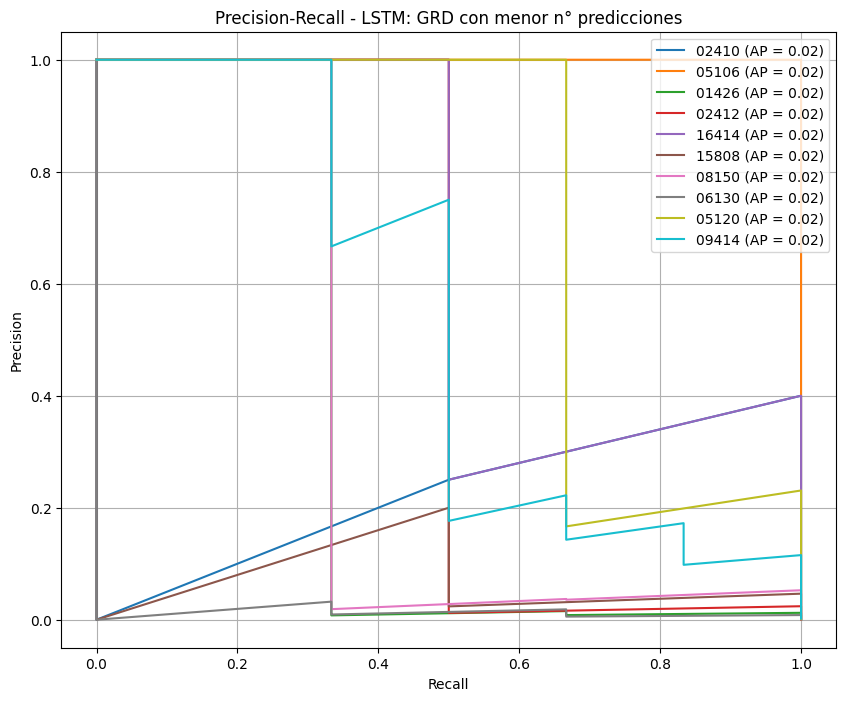

In [ ]:
target_grds = ['02410', '05106', '01426', '02412',
               '16414', '15808', '08150', '06130',
               '05120', '09414']

target_indices = [np.where(target_encoder.classes_ == grd)[0][0] for grd in target_grds]

plt.figure(figsize=(10, 8))
for cls_idx in target_indices:
    plt.plot(recall[cls_idx], precision[cls_idx],
             label=f'{target_encoder.classes_[cls_idx]} (AP = {auc_score:.2f})')


plt.title(f'Precision-Recall - LSTM: GRD con menor n° predicciones')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.grid()
plt.show()